# Stable Diffusion 3 in KerasHub!

**Author:** [Hongyu Chiu](https://github.com/james77777778), [fchollet](https://twitter.com/fchollet), [lukewood](https://twitter.com/luke_wood_ml), [divamgupta](https://github.com/divamgupta)<br>
**Date created:** 2024/10/09<br>
**Last modified:** 2024/10/24<br>
**Description:** Image generation using KerasHub's Stable Diffusion 3 model.

## Overview

Stable Diffusion 3 is a powerful, open-source latent diffusion model (LDM)
designed to generate high-quality novel images based on text prompts. Released
by [Stability AI](https://stability.ai/), it was pre-trained on 1 billion
images and fine-tuned on 33 million high-quality aesthetic and preference images
, resulting in a greatly improved performance compared to previous version of
Stable Diffusion models.

In this guide, we will explore KerasHub's implementation of the
[Stable Diffusion 3 Medium](https://huggingface.co/stabilityai/stable-diffusion-3-medium)
including text-to-image, image-to-image and inpaint tasks.

To get started, let's install a few dependencies and get images for our demo:

In [1]:
!pip install -Uq keras
!pip install -Uq git+https://github.com/keras-team/keras-hub.git
!wget -O mountain_dog.png https://raw.githubusercontent.com/keras-team/keras-io/master/guides/img/stable_diffusion_3_in_keras_hub/mountain_dog.png
!wget -O mountain_dog_mask.png https://raw.githubusercontent.com/keras-team/keras-io/master/guides/img/stable_diffusion_3_in_keras_hub/mountain_dog_mask.png

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
--2024-11-15 21:54:22--  https://raw.githubusercontent.com/keras-team/keras-io/master/guides/img/stable_diffusion_3_in_keras_hub/mountain_dog.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecti

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import time

import keras
import keras_hub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Introduction

Before diving into how latent diffusion models work, let's start by generating
some images using KerasHub's APIs.

To avoid reinitializing variables for different tasks, we'll instantiate and
load the trained `backbone` and `preprocessor` using KerasHub's `from_preset`
factory method. If you only want to perform one task at a time, you can use a
simpler API like this:

```python
text_to_image = keras_hub.models.StableDiffusion3TextToImage.from_preset(
    "stable_diffusion_3_medium", dtype="float16"
)
```

That will automatically load and configure trained `backbone` and `preprocessor`
for you.

Note that in this guide, we'll use `image_shape=(512, 512, 3)` for faster
image generation. For higher-quality output, it's recommended to use the default
size of `1024`. Since the entire backbone has about 3 billion parameters, which
can be challenging to fit into a consumer-level GPU, we set `dtype="float16"` to
reduce the usage of GPU memory -- the officially released weights are also in
float16.

It is also worth noting that the preset "stable_diffusion_3_medium" excludes the
T5XXL text encoder, as it requires significantly more GPU memory. The performace
degradation is negligible in most cases. The weights, including T5XXL, will be
available on KerasHub soon.

In [3]:

def display_generated_images(images):
    """Helper function to display the images from the inputs.

    This function accepts the following input formats:
    - 3D numpy array.
    - 4D numpy array: concatenated horizontally.
    - List of 3D numpy arrays: concatenated horizontally.
    """
    display_image = None
    if isinstance(images, np.ndarray):
        if images.ndim == 3:
            display_image = Image.fromarray(images)
        elif images.ndim == 4:
            concated_images = np.concatenate(list(images), axis=1)
            display_image = Image.fromarray(concated_images)
    elif isinstance(images, list):
        concated_images = np.concatenate(images, axis=1)
        display_image = Image.fromarray(concated_images)

    if display_image is None:
        raise ValueError("Unsupported input format.")

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(display_image)
    plt.show()
    plt.close()


backbone = keras_hub.models.StableDiffusion3Backbone.from_preset(
    "stable_diffusion_3_medium", image_shape=(512, 512, 3), dtype="float16"
)
preprocessor = keras_hub.models.StableDiffusion3TextToImagePreprocessor.from_preset(
    "stable_diffusion_3_medium"
)
text_to_image = keras_hub.models.StableDiffusion3TextToImage(backbone, preprocessor)

100%|██████████| 3.07k/3.07k [00:00<00:00, 4.13MB/s]


100%|██████████| 5.57G/5.57G [02:22<00:00, 42.0MB/s]


100%|██████████| 4.08k/4.08k [00:00<00:00, 7.59MB/s]


100%|██████████| 976k/976k [00:00<00:00, 2.99MB/s]


100%|██████████| 512k/512k [00:00<00:00, 1.93MB/s]


100%|██████████| 976k/976k [00:00<00:00, 2.95MB/s]


100%|██████████| 512k/512k [00:00<00:00, 1.89MB/s]


Next, we give it a prompt:

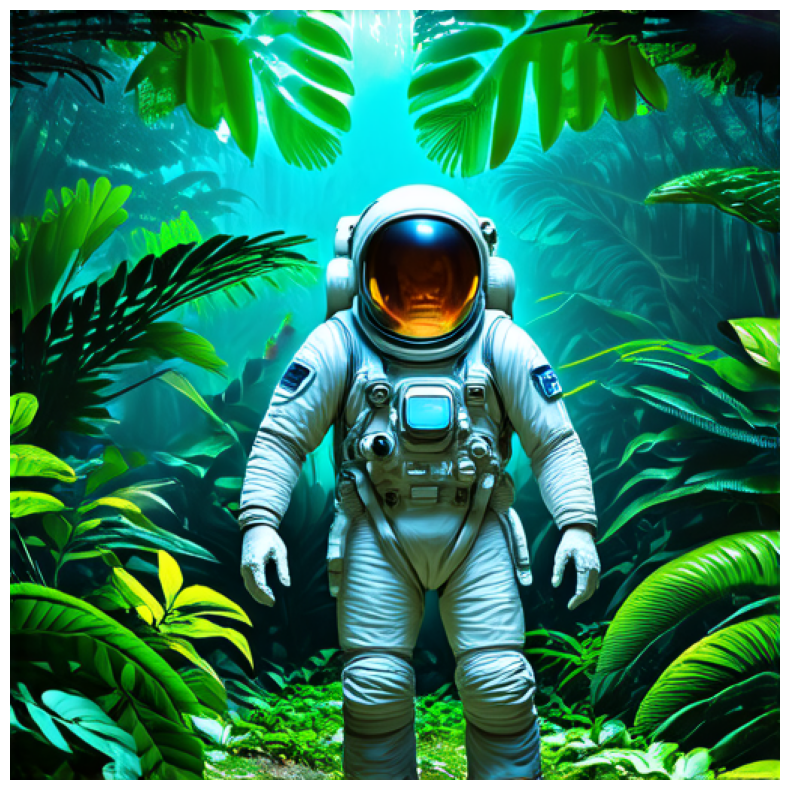

In [4]:
prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"

# When using JAX or TensorFlow backends, you might experience a significant
# compilation time during the first `generate()` call. The subsequent
# `generate()` call speedup highlights the power of JIT compilation and caching
# in frameworks like JAX and TensorFlow, making them well-suited for
# high-performance deep learning tasks like image generation.
generated_image = text_to_image.generate(prompt)
display_generated_images(generated_image)


Pretty impressive! But how does this work?

Let's dig into what "latent diffusion model" means.

Consider the concept of "super-resolution," where a deep learning model
"denoises" an input image, turning it into a higher-resolution version. The
model uses its training data distribution to hallucinate the visual details that
are most likely given the input. To learn more about super-resolution, you can
check out the following Keras.io tutorials:

- [Image Super-Resolution using an Efficient Sub-Pixel CNN](https://keras.io/examples/vision/super_resolution_sub_pixel/)
- [Enhanced Deep Residual Networks for single-image super-resolution](https://keras.io/examples/vision/edsr/)

![Super-resolution](https://i.imgur.com/M0XdqOo.png)

When we push this idea to the limit, we may start asking -- what if we just run
such a model on pure noise? The model would then "denoise the noise" and start
hallucinating a brand new image. By repeating the process multiple times, we
can get turn a small patch of noise into an increasingly clear and
high-resolution artificial picture.

This is the key idea of latent diffusion, proposed in
[High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).
To understand diffusion in depth, you can check the Keras.io tutorial
[Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/).

![Denoising diffusion](https://i.imgur.com/FSCKtZq.gif)

To transition from latent diffusion to a text-to-image system, one key feature
must be added: the ability to control the generated visual content using prompt
keywords. In Stable Diffusion 3, the text encoders from the CLIP and T5XXL
models are used to obtain text embeddings, which are then fed into the diffusion
model to condition the diffusion process. This approach is based on the concept
of "classifier-free guidance", proposed in
[Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).

When we combine these ideas, we get a high-level overview of the architecture of
Stable Diffusion 3:

- Text encoders: Convert the text prompt into text embeddings.
- Diffusion model: Repeatedly "denoises" a smaller latent image patch.
- Decoder: Transforms the final latent patch into a higher-resolution image.

First, the text prompt is projected into the latent space by multiple text
encoders, which are pretrained and frozen language models. Next, the text
embeddings, along with a randomly generated noise patch (typically from a
Gaussian distribution), are then fed into the diffusion model. The diffusion
model repeatly "denoises" the noise patch over a series of steps (the more
steps, the clearer and more refined the image becomes -- the default value is
28 steps). Finally, the latent patch is passed through the decoder from the VAE
model to render the image in high resolution.

The overview of the Stable Diffusion 3 architecture:
![The Stable Diffusion 3 architecture](https://i.imgur.com/D9y0fWF.png)

This relatively simple system starts looking like magic once we train on
billions of pictures and their captions. As Feynman said about the universe:
_"It's not complicated, it's just a lot of it!"_

## Text-to-image task

Now we know the basis of the Stable Diffusion 3 and the text-to-image task.
Let's explore further using KerasHub APIs.

To use KerasHub's APIs for efficient batch processing, we can provide the model
with a list of prompts:

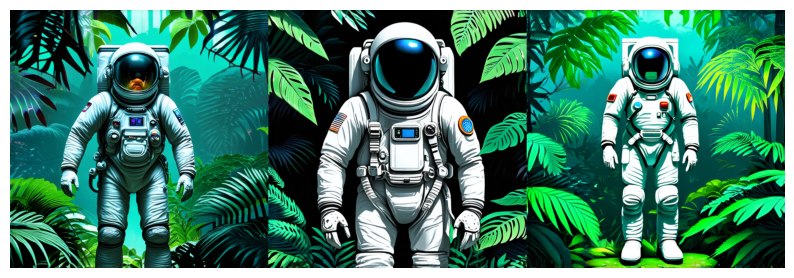

In [5]:

generated_images = text_to_image.generate([prompt] * 3)
display_generated_images(generated_images)

The `num_steps` parameter controls the number of denoising steps used during
image generation. Increasing the number of steps typically leads to higher
quality images at the expense of increased generation time. In
Stable Diffusion 3, this parameter defaults to `28`.

Cost time (`num_steps=10`): 4.20s
Cost time (`num_steps=28`): 10.56s
Cost time (`num_steps=50`): 17.93s


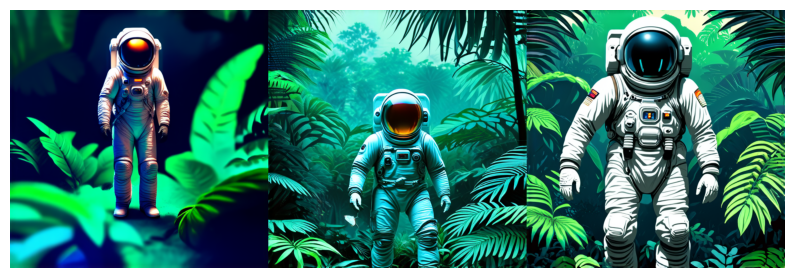

In [6]:
num_steps = [10, 28, 50]
generated_images = []
for n in num_steps:
    st = time.time()
    generated_images.append(text_to_image.generate(prompt, num_steps=n))
    print(f"Cost time (`num_steps={n}`): {time.time() - st:.2f}s")

display_generated_images(generated_images)

We can use `"negative_prompts"` to guide the model away from generating specific
styles and elements. The input format becomes a dict with the keys `"prompts"`
and `"negative_prompts"`.

If `"negative_prompts"` is not provided, it will be interpreted as an
unconditioned prompt with the default value of `""`.

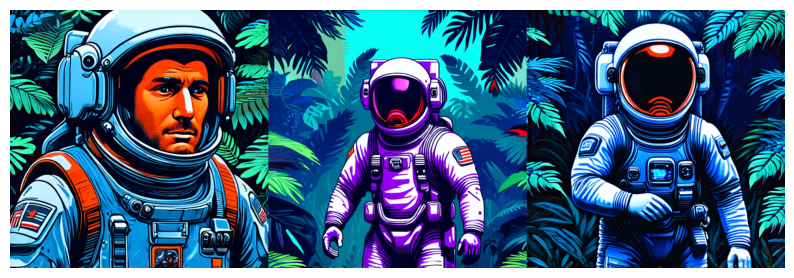

In [7]:
generated_images = text_to_image.generate(
    {
        "prompts": [prompt] * 3,
        "negative_prompts": ["Green color"] * 3,
    }
)
display_generated_images(generated_images)

`guidance_scale` affects how much the `"prompts"` influences image generation.
A lower value gives the model creativity to generate images that are more
loosely related to the prompt. Higher values push the model to follow the prompt
more closely. If this value is too high, you may observe some artifacts in the
generated image. In Stable Diffusion 3, it defaults to `7.0`.

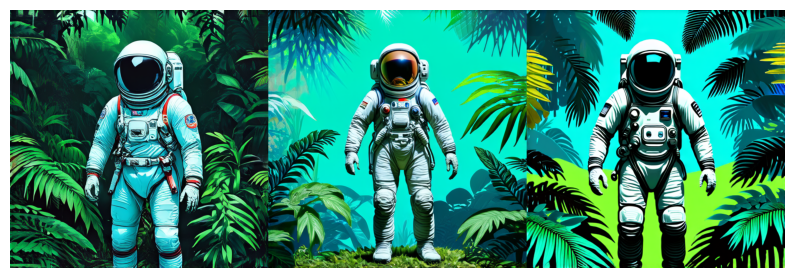

In [8]:
generated_images = [
    text_to_image.generate(prompt, guidance_scale=2.5),
    text_to_image.generate(prompt, guidance_scale=7.0),
    text_to_image.generate(prompt, guidance_scale=10.5),
]
display_generated_images(generated_images)

Note that `negative_prompts` and `guidance_scale` are related. The formula in
the implementation can be represented as follows:
`predicted_noise = negative_noise + guidance_scale * (positive_noise - negative_noise)`.

## Image-to-image task

A reference image can be used as a starting point for the diffusion process.
This requires an additional module in the pipeline: the encoder from the VAE
model.

The reference image is encoded by the VAE encoder into the latent space, where
noise is then added. The subsequent denoising steps follow the same procedure as
the text-to-image task.

The input format becomes a dict with the keys `"images"`, `"prompts"` and
optionally `"negative_prompts"`.

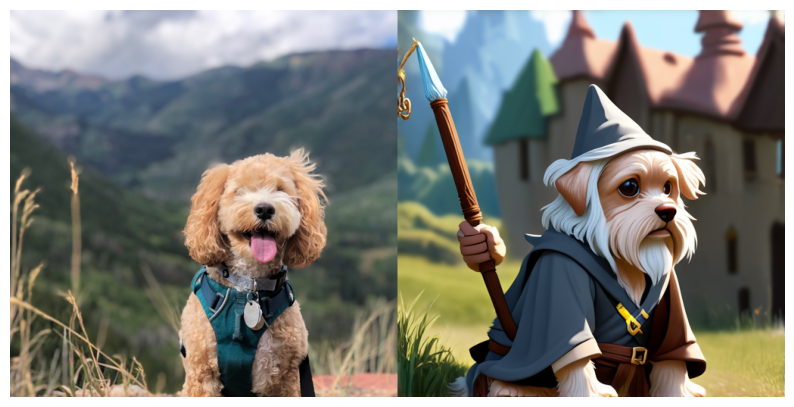

In [9]:
image_to_image = keras_hub.models.StableDiffusion3ImageToImage(backbone, preprocessor)

image = Image.open("mountain_dog.png").convert("RGB")
image = image.resize((512, 512))
width, height = image.size

# Note that the values of the image must be in the range of [-1.0, 1.0].
rescale = keras.layers.Rescaling(scale=1 / 127.5, offset=-1.0)
image_array = rescale(np.array(image))

prompt = "dog wizard, gandalf, lord of the rings, detailed, fantasy, cute, "
prompt += "adorable, Pixar, Disney, 8k"

generated_image = image_to_image.generate(
    {
        "images": image_array,
        "prompts": prompt,
    }
)
display_generated_images(
    [
        np.array(image),
        generated_image,
    ]
)

As you can see, a new image is generated based on the reference image and the
prompt.

The `strength` parameter plays a key role in determining how closely the
generated image resembles the reference image. The value ranges from
`[0.0, 1.0]` and defaults to `0.8` in Stable Diffusion 3.

A higher `strength` value gives the model more “creativity” to generate an image
that is different from the reference image. At a value of `1.0`, the reference
image is completely ignored, making the task purely text-to-image.

A lower `strength` value means the generated image is more similar to the
reference image.

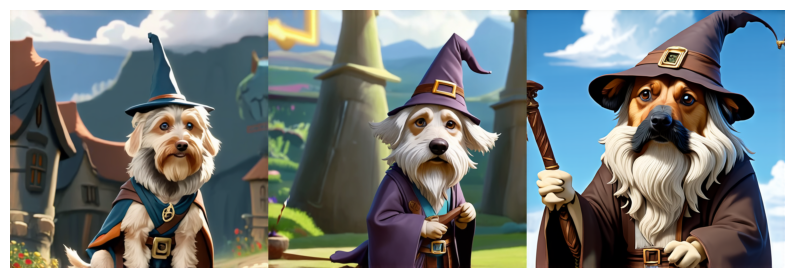

In [10]:
generated_images = [
    image_to_image.generate(
        {
            "images": image_array,
            "prompts": prompt,
        },
        strength=0.7,
    ),
    image_to_image.generate(
        {
            "images": image_array,
            "prompts": prompt,
        },
        strength=0.8,
    ),
    image_to_image.generate(
        {
            "images": image_array,
            "prompts": prompt,
        },
        strength=0.9,
    ),
]
display_generated_images(generated_images)

## Inpaint task

Building upon the image-to-image task, we can also control the generated area
using a mask. This process is called inpainting, where specific areas of an
image are replaced or edited.

Inpainting relies on a mask to determine which regions of the image to modify.
The areas to inpaint are represented by white pixels (`True`), while the areas
to preserve are represented by black pixels (`False`).

For inpainting, the input is a dict with the keys `"images"`, `"masks"`,
`"prompts"` and optionally `"negative_prompts"`.

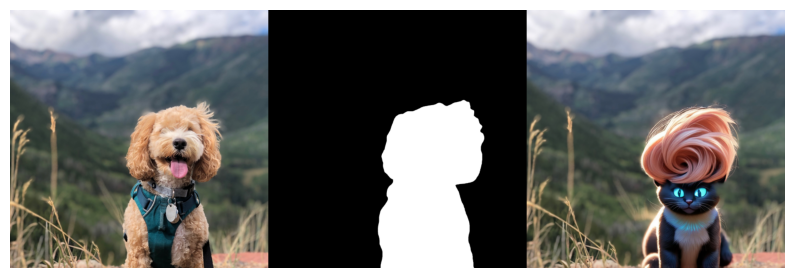

In [11]:
inpaint = keras_hub.models.StableDiffusion3Inpaint(backbone, preprocessor)

image = Image.open("mountain_dog.png").convert("RGB")
image = image.resize((512, 512))
image_array = rescale(np.array(image))

# Note that the mask values are of boolean dtype.
mask = Image.open("mountain_dog_mask.png").convert("L")
mask = mask.resize((512, 512))
mask_array = np.array(mask).astype("bool")

prompt = "a black cat with glowing eyes, cute, adorable, disney, pixar, highly "
prompt += "detailed, 8k"

generated_image = inpaint.generate(
    {
        "images": image_array,
        "masks": mask_array,
        "prompts": prompt,
    }
)
display_generated_images(
    [
        np.array(image),
        np.array(mask.convert("RGB")),
        generated_image,
    ]
)

Fantastic! The dog is replaced by a cute black cat, but unlike image-to-image,
the background is preserved.

Note that inpainting task also includes `strength` parameter to control the
image generation, with the default value of `0.6` in Stable Diffusion 3.

## Conclusion

KerasHub's `StableDiffusion3` supports a variety of applications and, with the
help of Keras 3, enables running the model on TensorFlow, JAX, and PyTorch!

In [15]:
pip install torch torchvision diffusers opencv-python-headless


In [19]:
import os
import cv2
import numpy as np
import torch
from diffusers import StableDiffusionPipeline
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
from huggingface_hub import login

# Optional: Hugging Face Authentication
try:
    login("your_huggingface_token")  # Replace with your actual token if needed
except Exception as e:
    print("Hugging Face authentication failed. Continuing without it.")

# Force the use of CPU
device = "cpu"
print(f"Using device: {device}")

# Load the Stable Diffusion model with optimizations for CPU usage
model_id = "CompVis/stable-diffusion-v1-4"
try:
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float32,  # Use float32 on CPU for better precision
        resume_download=True,
        timeout=120
    )
    pipe.enable_attention_slicing()
    pipe = pipe.to(device)
except Exception as e:
    print(f"Error loading model: {e}")
    exit(1)

# User input for the text prompt
user_prompt = input("Enter your text prompt for the video: ")

# Video parameters
video_filename = "text_to_video_output_cpu.avi"
frame_width, frame_height = 512, 512
fps = 24
video_duration = 60  # 1 minute in seconds
total_frames = fps * video_duration
batch_size = 2  # Adjusted batch size to be smaller for CPU processing

# Create a video writer object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_filename, fourcc, fps, (frame_width, frame_height))

# Function to generate images from prompts
def generate_images_from_prompts(prompts):
    with torch.no_grad():
        images = pipe(prompts, height=frame_height, width=frame_width).images
    return [np.array(img)[:, :, ::-1] for img in images]  # Convert to OpenCV BGR format

# Function to modify the prompt for each frame
def modify_prompt_for_frame(prompt, frame_index, total_frames):
    return f"{prompt}, cinematic scene transition, frame {frame_index}/{total_frames}"

# Function to generate and write frames to the video
def generate_and_write_frames(batch_start, batch_end):
    batch_end = min(batch_end, total_frames)
    prompts = [modify_prompt_for_frame(user_prompt, i, total_frames) for i in range(batch_start, batch_end)]

    if len(prompts) == 0:
        return

    try:
        images_bgr = generate_images_from_prompts(prompts)
        for img in images_bgr:
            out.write(img)
    except Exception as e:
        print(f"Error processing batch: {e}")

# Generate video without parallel processing since we're on CPU
def generate_video():
    batch_count = (total_frames + batch_size - 1) // batch_size
    for batch_index in range(batch_count):
        batch_start = batch_index * batch_size
        batch_end = (batch_index + 1) * batch_size

        if batch_start >= total_frames:
            break

        generate_and_write_frames(batch_start, batch_end)
        print(f"Processed batch {batch_index + 1}/{batch_count}")

# Start generating the video
start_time = time.time()
print("Generating video on CPU... Please wait.")
try:
    generate_video()
except Exception as e:
    print(f"Error during video generation: {e}")

# Release the video writer object
out.release()

# Calculate and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Video generated successfully in {elapsed_time:.2f} seconds for {total_frames} frames.")

# Optional: Show the generated video (playback)
cap = cv2.VideoCapture(video_filename)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imshow('Generated Video', frame)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

print(f"Video saved to {video_filename}")


Keyword arguments {'resume_download': True, 'timeout': 120} are not expected by StableDiffusionPipeline and will be ignored.


Hugging Face authentication failed. Continuing without it.
Using device: cpu


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Enter your text prompt for the video: space craft
Generating video on CPU... Please wait.


  0%|          | 0/50 [00:00<?, ?it/s]

Processed batch 1/720


  0%|          | 0/50 [00:00<?, ?it/s]

Processed batch 2/720


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import os
import cv2
import numpy as np
import torch
from diffusers import StableDiffusionPipeline
import time
from huggingface_hub import login

# Optional: Hugging Face Authentication (replace with your actual token if needed)
try:
    login("your_huggingface_token")  # Replace with your actual token if needed
except Exception as e:
    print("Hugging Face authentication failed. Continuing without it.")

# Function to attempt loading the model on GPU, specifically T4 GPU
def load_model_on_device():
    try:
        # Check if GPU is available
        device = "cuda" if torch.cuda.is_available() else "cpu"

        # If GPU is available, check if it's a T4
        if device == "cuda":
            gpu_name = torch.cuda.get_device_name(0)
            if "T4" in gpu_name:
                print(f"T4 GPU detected: {gpu_name}")
            else:
                print(f"Using GPU: {gpu_name}, but it's not a T4.")
        else:
            print("GPU not available, falling back to CPU.")

        print(f"Trying to use device: {device}")

        # Load the Stable Diffusion model with optimizations for GPU usage (fp16)
        model_id = "CompVis/stable-diffusion-v1-4"
        pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16


In [22]:
import os
import cv2
import numpy as np
import torch
from diffusers import StableDiffusionPipeline
import time
from huggingface_hub import login

# Optional: Hugging Face Authentication (replace with your actual token if needed)
try:
    login("your_huggingface_token")  # Replace with your actual token if needed
except Exception as e:
    print("Hugging Face authentication failed. Continuing without it.")

# Function to attempt loading the model on GPU, specifically T4 GPU
def load_model_on_device():
    try:
        # Check if GPU is available
        device = "cuda" if torch.cuda.is_available() else "cpu"

        # If GPU is available, check if it's a T4
        if device == "cuda":
            gpu_name = torch.cuda.get_device_name(0)
            if "T4" in gpu_name:
                print(f"T4 GPU detected: {gpu_name}")
            else:
                print(f"Using GPU: {gpu_name}, but it's not a T4.")
        else:
            print("GPU not available, falling back to CPU.")

        print(f"Trying to use device: {device}")

        # Load the Stable Diffusion model with optimizations for GPU usage (fp16)
        model_id = "CompVis/stable-diffusion-v1-4"
        pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,  # Use float16 for GPU, float32 for CPU
            resume_download=True,
            timeout=120
        )
        pipe.enable_attention_slicing()  # Optimize inference speed
        pipe = pipe.to(device)

        print(f"Model loaded successfully on {device}.")
        return pipe, device
    except RuntimeError as e:
        # If there is a CUDA memory error or any GPU issue, fall back to CPU
        print(f"GPU error occurred: {e}. Falling back to CPU.")
        device = "cpu"
        pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float32,  # Use float32 for CPU
            resume_download=True,
            timeout=120
        )
        pipe = pipe.to(device)
        print("Model loaded successfully on CPU.")
        return pipe, device

# Load the model and get the device (GPU or CPU)
pipe, device = load_model_on_device()

# User input for the text prompt
user_prompt = input("Enter your base text prompt for the video (e.g., 'fashion runway scene'): ")

# Video parameters
video_filename = "/content/creative_runway_video_gpu_fallback.avi"
frame_width, frame_height = 512, 512
fps = 24
video_duration = 10  # Duration in seconds (adjust as needed)
total_frames = fps * video_duration

# Create a video writer object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_filename, fourcc, fps, (frame_width, frame_height))

# Function to generate an image from a prompt
def generate_image(prompt):
    with torch.no_grad():
        image = pipe(prompt, height=frame_height, width=frame_width).images[0]
    return np.array(image)[:, :, ::-1]  # Convert to OpenCV BGR format

# Function to dynamically modify the prompt for each frame for creative variety
def modify_prompt_for_frame(prompt, frame_index, total_frames):
    # Modify scene to add progression, lighting, and setting variation
    if frame_index < total_frames // 3:
        lighting = "bright runway lights"
        scene = "a stylish model walking on a fashion runway"
    elif frame_index < 2 * total_frames // 3:
        lighting = "soft ambient lighting"
        scene = "a model posing in a luxurious fashion hall"
    else:
        lighting = "dramatic spotlight"
        scene = "a futuristic runway with a digital backdrop"

    # Add progression to the scene description to make it dynamic and cinematic
    prompt = f"{prompt}, {scene}, with {lighting}, elegant atmosphere, frame {frame_index + 1}/{total_frames}"
    return prompt

# Generate each frame and write to the video
start_time = time.time()
print("Generating creative video... Please wait.")
try:
    for i in range(total_frames):
        # Dynamically modify the prompt for each frame to create creative variations
        prompt = modify_prompt_for_frame(user_prompt, i, total_frames)
        print(f"Generating frame {i + 1}/{total_frames}")

        # Generate the image
        img = generate_image(prompt)

        # Write the frame to the video
        out.write(img)

except Exception as e:
    print(f"Error generating frames: {e}")

# Release the video writer object
out.release()

elapsed_time = time.time() - start_time
print(f"Creative video generated successfully in {elapsed_time:.2f} seconds and saved as '{video_filename}'.")

# Play the generated video using OpenCV
cap = cv2.VideoCapture(video_filename)
print("Playing generated video. Press 'q' to quit.")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imshow('Generated Creative Video', frame)
    if cv2.waitKey(20) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Video playback finished.")


Hugging Face authentication failed. Continuing without it.
T4 GPU detected: Tesla T4
Trying to use device: cuda


Keyword arguments {'resume_download': True, 'timeout': 120} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Model loaded successfully on cuda.
Generating creative video... Please wait.
Generating frame 1/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 2/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 3/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 4/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 5/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 6/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 7/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 8/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 9/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 10/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 11/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 12/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 13/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 14/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 15/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 16/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 17/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 18/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 19/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 20/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 21/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 22/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 23/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 24/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 25/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 26/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 27/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 28/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 29/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 30/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 31/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 32/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 33/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 34/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 35/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 36/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 37/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 38/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 39/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 40/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 41/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 42/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 43/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 44/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 45/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 46/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 47/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 48/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 49/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 50/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 51/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 52/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 53/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 54/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 55/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 56/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 57/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 58/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 59/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 60/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 61/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 62/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 63/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 64/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 65/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 66/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 67/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 68/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 69/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 70/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 71/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 72/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 73/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 74/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 75/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 76/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 77/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 78/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 79/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 80/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 81/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 82/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 83/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 84/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 85/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 86/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 87/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 88/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 89/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 90/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 91/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 92/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 93/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 94/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 95/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 96/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 97/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 98/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 99/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 100/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 101/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 102/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 103/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 104/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 105/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 106/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 107/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 108/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 109/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 110/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 111/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 112/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 113/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 114/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 115/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 116/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 117/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 118/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 119/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 120/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 121/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 122/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 123/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 124/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 125/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 126/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 127/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 128/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 129/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 130/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 131/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 132/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 133/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 134/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 135/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 136/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 137/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 138/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 139/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 140/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 141/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 142/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 143/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 144/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 145/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 146/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 147/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 148/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 149/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 150/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 151/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 152/240


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating frame 153/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 154/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 155/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 156/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 157/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 158/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 159/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 160/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 161/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 162/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 163/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 164/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 165/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 166/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 167/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 168/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 169/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 170/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 171/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 172/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 173/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 174/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 175/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 176/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 177/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 178/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 179/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 180/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 181/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 182/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 183/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 184/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 185/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 186/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 187/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 188/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 189/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 190/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 191/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 192/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 193/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 194/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 195/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 196/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 197/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 198/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 199/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 200/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 201/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 202/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 203/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 204/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 205/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 206/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 207/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 208/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 209/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 210/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 211/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 212/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 213/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 214/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 215/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 216/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 217/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 218/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 219/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 220/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 221/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 222/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 223/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 224/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 225/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 226/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 227/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 228/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 229/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 230/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 231/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 232/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 233/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 234/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 235/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 236/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 237/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 238/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 239/240


  0%|          | 0/50 [00:00<?, ?it/s]

Generating frame 240/240


  0%|          | 0/50 [00:00<?, ?it/s]

Creative video generated successfully in 2568.61 seconds and saved as '/content/creative_runway_video_gpu_fallback.avi'.
Playing generated video. Press 'q' to quit.


DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow
